In [26]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import random
import json
from networkx.readwrite import json_graph

# Função auxiliar para converter tipos do NumPy para tipos nativos do Python
def convert_to_native(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, (list, tuple)):
        return [convert_to_native(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_native(value) for key, value in obj.items()}
    else:
        return obj

# Parâmetros da grid (cidade)
rows, cols = 15, 15  # Alterar para tamanho desejado da cidade
L, K = 2, 5  # Comprimento mínimo e máximo das ruas
regions = 12  # Alterar para o número desejado de regiões

# Criando um grafo em formato de grid
city_grid = nx.grid_2d_graph(rows, cols)

# Convertendo os nós para um formato mais legível
mapping = {(x, y): f"{x},{y}" for x, y in city_grid.nodes()}
city_grid = nx.relabel_nodes(city_grid, mapping)

# Plotando o grafo em formato de grid
pos = {node: (int(node.split(",")[1]), -int(node.split(",")[0])) for node in city_grid.nodes()}

# Número de regiões (clusters)

# Convertendo posições dos nós para um array para clusterização
node_positions = np.array([pos[node] for node in city_grid.nodes()])
kmeans = KMeans(n_clusters=regions, random_state=42).fit(node_positions)
labels = kmeans.labels_

# Criando um dicionário de cores para as regiões
colors = plt.cm.get_cmap('tab10', regions).colors  # Usando um colormap com L cores
region_colors = {i: colors[i] for i in range(regions)}

# Dividindo as arestas em regiões com base nos clusters de nós
edge_regions = {}  # Dicionário para armazenar a região de cada aresta
for edge in city_grid.edges():
    node1, node2 = edge
    region1 = labels[list(city_grid.nodes()).index(node1)]
    region2 = labels[list(city_grid.nodes()).index(node2)]
    # Aresta pertence à região do nó inicial (ou uma regra diferente pode ser usada)
    edge_regions[edge] = region1 if region1 == region2 else min(region1, region2)

# Criando ruas
streets = {}  # Dicionário para armazenar as ruas
street_id = 1
edge_street_map = {}  # Para mapear cada aresta ao número da rua

# Função para criar ruas em uma direção
def create_street(edges, direction):
    global street_id
    street_edges = []
    current_length = 0

    # Ordenar as arestas para garantir que as ruas sejam paralelas
    edges = sorted(edges, key=lambda edge: (
        int(edge[0].split(",")[0]), int(edge[0].split(",")[1])) if direction == "horizontal" else (
        int(edge[0].split(",")[1]), int(edge[0].split(",")[0]))
    )

    last_line = None

    for edge in edges:
        current_line = int(edge[0].split(",")[0]) if direction == "horizontal" else int(edge[0].split(",")[1])

        # Verifica se mudou de linha/coluna ou chegou ao limite do grid/região
        if current_line != last_line or current_length >= K or (current_length >= L and random.random() > 0.5):
            # Finaliza a rua atual
            if street_edges:
                for e in street_edges:
                    edge_street_map[e] = street_id
                streets[street_id] = street_edges
                street_id += 1
            street_edges = []
            current_length = 0

        # Adiciona a aresta atual à rua
        street_edges.append(edge)
        current_length += 1
        last_line = current_line

    # Finaliza qualquer rua restante
    if street_edges:
        for e in street_edges:
            edge_street_map[e] = street_id
        streets[street_id] = street_edges
        street_id += 1

# Criando ruas horizontais e verticais para cada região
for region in range(regions):
    # Obter arestas da região
    region_edges = [edge for edge in city_grid.edges() if edge_regions[edge] == region]

    # Dividir em horizontais e verticais
    horizontal_edges = [edge for edge in region_edges if edge[0].split(",")[0] == edge[1].split(",")[0]]
    vertical_edges = [edge for edge in region_edges if edge[0].split(",")[1] == edge[1].split(",")[1]]

    # Criar ruas horizontais e verticais
    create_street(horizontal_edges, direction="horizontal")
    create_street(vertical_edges, direction="vertical")

# Atribuindo atributos às arestas, garantindo tipos nativos
street = 1000
cep_cont = 100000
for edge in city_grid.edges():
    street_number = street #edge_street_map.get(edge, None)  # Número da rua
    cep = cep_cont #edge_regions.get(edge, None)             # Região (CEP)
    transito = random.uniform(0, 1)                # Trânsito (valor aleatório entre 0 e 1)
    street += 1
    cep_cont+=1

    # Adiciona os atributos à aresta no grafo, garantindo tipos nativos
    if street_number is not None and cep is not None:
        city_grid.edges[edge]['street_number'] = int(street_number)
        city_grid.edges[edge]['cep'] = int(cep)
        city_grid.edges[edge]['transito'] = float(transito)



# Convertendo o grafo para o formato node-link
data = json_graph.node_link_data(city_grid)
data = convert_to_native(data)

# Modificando os dados para atender às especificações
data['vertex'] = []
for node in data['nodes']:
    data['vertex'].append({
        "id_vertex": node['id'],
        "isMetroStation": False
    })
del data['nodes']

data['edges'] = []
for i, link in enumerate(data['links']):
    id_edge = i + 1
    new_edge = {
        "id_edge": id_edge,
        "v1": link['source'],
        "v2": link['target'],
        "street_number": street_number,
        "cep": cep ,
        "traficRate": transito,
        "distance": random.randint(5, 10)
    }
    data['edges'].append(new_edge)
del data['links']

# Salvando o JSON final
with open('modified_city_graph.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)


C:\Users\Paula Eduarda\AppData\Local\Temp\ipykernel_11820\237187560.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', regions).colors  # Usando um colormap com L cores
c:\Users\Paula Eduarda\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


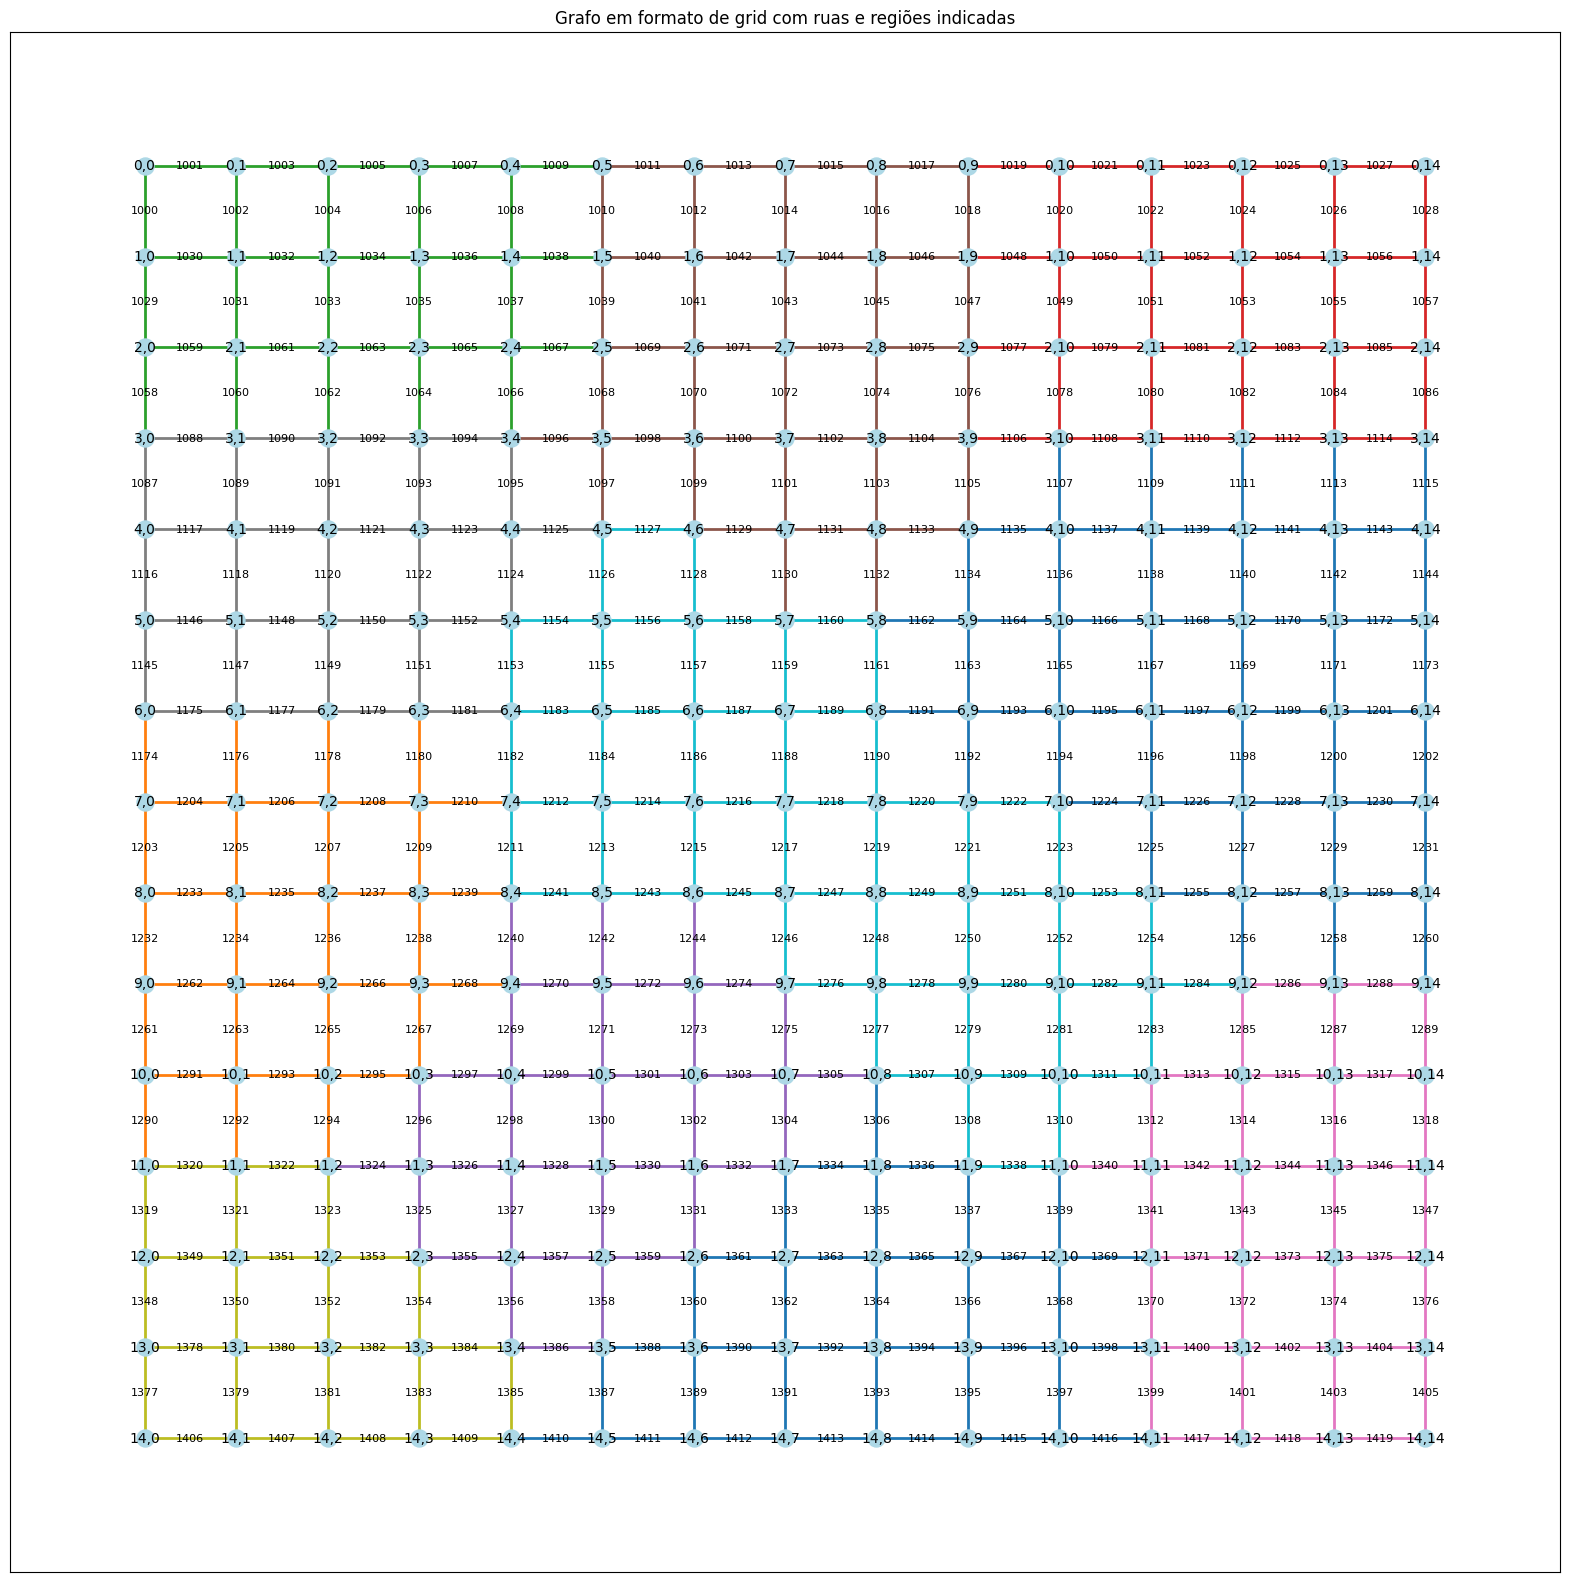

Rua 1: [('4,9', '4,10'), ('4,10', '4,11'), ('4,11', '4,12')]
Rua 2: [('4,12', '4,13'), ('4,13', '4,14')]
Rua 3: [('5,8', '5,9'), ('5,9', '5,10')]
Rua 4: [('5,10', '5,11'), ('5,11', '5,12')]
Rua 5: [('5,12', '5,13'), ('5,13', '5,14')]
Rua 6: [('6,8', '6,9'), ('6,9', '6,10'), ('6,10', '6,11')]
Rua 7: [('6,11', '6,12'), ('6,12', '6,13')]
Rua 8: [('6,13', '6,14')]
Rua 9: [('7,10', '7,11'), ('7,11', '7,12')]
Rua 10: [('7,12', '7,13'), ('7,13', '7,14')]
Rua 11: [('8,11', '8,12'), ('8,12', '8,13'), ('8,13', '8,14')]
Rua 12: [('4,9', '5,9'), ('5,9', '6,9'), ('6,9', '7,9')]
Rua 13: [('3,10', '4,10'), ('4,10', '5,10')]
Rua 14: [('5,10', '6,10'), ('6,10', '7,10')]
Rua 15: [('3,11', '4,11'), ('4,11', '5,11')]
Rua 16: [('5,11', '6,11'), ('6,11', '7,11')]
Rua 17: [('7,11', '8,11')]
Rua 18: [('3,12', '4,12'), ('4,12', '5,12'), ('5,12', '6,12')]
Rua 19: [('6,12', '7,12'), ('7,12', '8,12'), ('8,12', '9,12')]
Rua 20: [('3,13', '4,13'), ('4,13', '5,13'), ('5,13', '6,13'), ('6,13', '7,13'), ('7,13', '8,13

In [27]:
# Criando lista de cores para as arestas com base na região
edge_colors = [region_colors[edge_regions[edge]] for edge in city_grid.edges()]

# Plotando o grafo com ruas
plt.figure(figsize=(20, 20))

nx.draw_networkx_edges(
    city_grid,
    pos,
    edge_color=edge_colors,
    width=2,
)

# Adicionando etiquetas para identificar as ruas
for edge in city_grid.edges():
    if edge in edge_street_map:
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        plt.text(mid_x, mid_y, int(city_grid.edges[edge]['street_number']), fontsize=8, color="black", ha="center", va="center")

# Desenhando os nós por cima para clareza
nx.draw_networkx_nodes(city_grid, pos, node_color='lightblue', node_size=150)
nx.draw_networkx_labels(city_grid, pos, font_size=10)

plt.title("Grafo em formato de grid com ruas e regiões indicadas")
plt.show()

# Exibir ruas criadas
for street, edges in streets.items():
    print(f"Rua {street}: {edges}")

# Converter o grafo para o formato node-link
data = json_graph.node_link_data(city_grid)

# Converter todos os valores para tipos nativos
data = convert_to_native(data)

# Salvar o grafo no arquivo JSON
with open('city_graph.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print("Grafo exportado com sucesso para 'city_graph.json'")